**Summary of functions and display/animation routines:**

* Import external libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML

Particle calss defined, here the mass can be ignored, because p=mv, the mass is a linear scaler, m=1 [unit] -> p=1[unit]v=v[unit]

In [2]:
class Particle:
    def __init__(self, r:float|int, x:float|int, y:float|int, vx:float|int, vy:float|int):
        self.r:float|int=r
        self.x:float|int=x
        self.y:float|int=y
        self.vx:float|int=vx
        self.vy:float|int=vy
        
    def __repr__(self):
         return(str("This is a particle at %0.2f, %0.2f with v=%0.2f,%0.2f" % (self.x,self.y,self.vx,self.vy)) )


Here I introduce the nearest neighbour search. system shift translates into 

In [3]:
def system_shift(p1:Particle,box:tuple[float|int]) -> tuple[float|int]:
    (dx,dy) = (p1.x-box[0]/2 , p1.y-box[1]/2)
    return(dx,dy)

### vec(p2->p1)
def rel_koordiantes(p1:Particle,p2:Particle,box:tuple[float|int]) -> tuple[float|int]:  
    dx, dy = system_shift(p1,box)  # S->S': S' is a box with p1' at its center
    #  print("10,10=",p1.x+dx,p1.y+dy)
    #  print("p2'=",(p2.x+dx)%box[0], (p2.y+dy)%box[1])
    #  print("rel koordiantes=", (p1.x+dx - (p2.x+dx)%box[0] , p1.y+dy - (p2.y+dy)%box[1]))
    return(p1.x +dx - (p2.x-dx)%box[0] , p1.y +dy - (p2.y-dy)%box[1])


* functions to collect data 

In [4]:
### calculating distributions
### |v| distribution
def collect_vabs(vx:list[list[float|int]],vy:list[list[float|int]],interval:tuple[int]) -> list[float]:
    v_abs=np.zeros(len(vx)+(interval[1]-interval[0]))
    for i in range(len(vx)):
        for j in range(interval[0],interval[1]):
            v_abs[i+j-interval[0]]=(np.sqrt(vx[i][j]**2+vy[i][j]**2))
    return v_abs

### velocity x or y distribution
def collect_v_1D(vx:list[float|int],interval:tuple[int]) -> list[float]:
    l=np.zeros(len(vx)+(interval[1]-interval[0]))
    print(len(l))
    for i in range(len(vx)):
        for j in range(interval[0],interval[1]):
            l[i+j-interval[0]]=(vx[i][j])
    return l


### Maxwell Boltzmann distribution 
def mw_boltzmann_distri(v_intervall:tuple[float|int], T:float|int)->tuple[list[float]]: 
    v=np.linspace(v_intervall[0],v_intervall[1],200) 
    p=4*np.pi/(2*np.pi*T)**(3/2)*v**2 * np.exp(-v**2/2/T)  # k_B=1, m=1
    return (v,p)


Here are the animation functions, for these functions I asked chat gpt to help out. Though I thought it to be usefull to include the animation_plot-function.

In [5]:
def animate(frame, x_data, y_data, scat):
    positions = np.c_[x_data[:, frame], y_data[:, frame]]
    scat.set_offsets(positions)
    return scat,
def animation_plot(p_radius:float|int,box:tuple[float|int]):
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], s=p_radius)  # Scale size for visibility
    ax.set_xlim(box[0])
    ax.set_ylim(box[1])
    ax.set_title("Simulation Visualization")
    ax.set_xlabel("X [nm]")
    ax.set_ylabel("Y [nm]")
    return scat, fig, ax


* This is the "main" function or "run". First all the initial variables get initiated (e.g. box, n, initial velocities, list of particles,...). 
* Then the first "for loop" over T (total timesteps) is the main simulation loop.
* The second loop, looping over all particles i searches is to update all the positions according to Eulers integration sceem
* The third loop, looping all j > i, is to determine the collisions, if they take place or not. Updating both velocities of i and j. Thus we iterate for j > i.

* first the velocities get updated, then the positions get updated then the positions and velocities get saved to an array

* the animation video gets saved as a ".gif" and the plots too are saved into your folder! Please be aware!

250
250
250
250


MovieWriter ffmpeg unavailable; using Pillow instead.


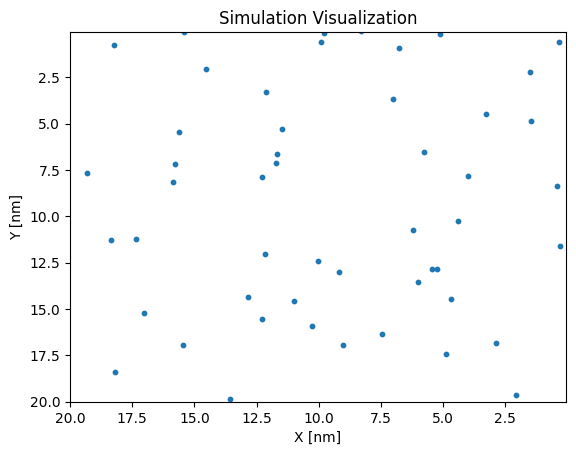

Initiating
n_particles=50
timesteps=2000
timestep=1.0
box=(20, 20)
Simulation complete!
plots success



In [6]:
def run():
    log="Initiating\n"
    box:tuple[float|int]=(20,20)  # nm
    n:int=50  # nuber of particles
    r:float|int=1.0  # nm
    v0:float|int=1.0   # nm/tau
    k_B=1  # as such will noch be used to multiply
    temp:float = v0**2/2  # temperature of a system <E_kin> =dim/2 * k_B * T
    angles:list[float]=np.random.rand(n)*2*np.pi
    par:list[Particle]=[Particle(
            r,
            np.random.randint(1,box[0]-1,1)[0],
            np.random.randint(1,box[1]-1,1)[0],
            v0*np.cos(angles[i]),
            v0*np.sin(angles[i])
            )
        for i in range(n)]   

    T:int=2000  #  total time
    dt:float=1.0  # tau
    log = log + "n_particles=" +str(n)+"\ntimesteps="+str(T)+"\ntimestep="+str(dt)+"\nbox="+str(box)+"\n" 

    x_data=np.zeros((n,T))
    y_data=np.zeros((n,T))
    vx_data=np.zeros((n,T))
    vy_data=np.zeros((n,T))
    ### Simulation
    for t in range(T):
        ### iterate all particles
        for i in range(n):
            #  print("iter i=",i)
            ### collision
            for j in range(i+1,n):  # iteration over all others
                #  print("iter j=", j)
                d_vec:tuple[float|int] = rel_koordiantes(par[i],par[j], box)  # rel. distance vector j -> i
                d_abs = d_vec[0]**2+d_vec[1]**2  # distance squared
                #  print("distance vector",d_vec[0],d_vec[1])
                #  print("distance=",d_abs)
                #### collision condition -> kinematics
                if np.sqrt(d_abs) <= par[i].r+par[j].r and d_abs != 0:
                    d_unit:tuple[float|int] = d_vec/np.sqrt(d_abs)  # collision axis
                    #  print("!collision!: Axis",d_unit)
                    dvix , dviy= -((par[i].vx-par[j].vx)*d_unit[0]+ (par[i].vy-par[j].vy)*d_unit[1]) *d_unit
                    #  print("dv=",(dvix, dviy))
                    par[i].vx , par[i].vy = (par[i].vx+dvix) , ( par[i].vy+dviy)
                    par[j].vx , par[j].vy = (par[j].vx-dvix) , (par[j].vy-dviy)
            #  print("particle",i ," velocities:",par[i].vx,par[i].vy)

            par[i].x = (par[i].x+par[i].vx*dt) % box[0] 
            par[i].y = (par[i].y+par[i].vy*dt) % box[1]
            x_data[i][t]=par[i].x
            y_data[i][t]=par[i].y 
            vx_data[i][t]=par[i].vx
            vy_data[i][t]=par[i].vy
    log=log+"Simulation complete!\n"


    ### Analysis
    n_bins = 10

    ### collect vx
    vx1 = collect_v_1D(vx_data,(0,int(T/10)))
    vx2 = collect_v_1D(vx_data,(T-int(T/10),T))
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(vx1, bins=n_bins,density=False)
    axs[1].hist(vx2, bins=n_bins,density=False)
    plt.title("x-velocity distribution")
    axs[0].set_xlabel('vx [nm/tau]')
    axs[1].set_xlabel('vx [nm/tau]')
    axs[0].set_ylabel('p(vx)')
    plt.savefig("histograms-vx"+str(v0)+".png")
    plt.close()

    ### collect vy
    vy1 = collect_v_1D(vy_data,(0,int(T/10)))
    vy2 = collect_v_1D(vy_data,(T-int(T/10),T))
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(vy1, bins=n_bins,density=False)
    axs[1].hist(vy2, bins=n_bins,density=False)
    plt.title("y-velocity distributions")
    axs[0].set_xlabel('vx [nm/tau]')
    axs[1].set_xlabel('vx [nm/tau]')
    axs[0].set_ylabel('occupanvy')
    plt.savefig("histograms-vy"+str(v0)+".png")
    plt.close()

    ### absolute velocities
    v_abs1 = collect_vabs(vx_data,vy_data,(0,int(T/10)))
    v_abs2 = collect_vabs(vx_data,vy_data,(T-int(T/10),T))
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    plt.title("normed velocity distributions")
    plt.xlabel("|v| [nm/tau]")
    plt.ylabel("occupancy")
    axs[0].hist(v_abs1,n_bins,density=False)
    axs[1].hist(v_abs2,n_bins,density=False)
    axs[0].set_xlabel('|v| [nm/tau]')
    axs[1].set_xlabel('|v| [nm/tau]')
    axs[0].set_ylabel('occupancy')
    plt.savefig("maxwell_boltzmann-v_abs"+str(v0)+".png")
    plt.close()

    ### Maxwell Boltzmann distribution
    mw = mw_boltzmann_distri((0.0,1.75),temp)
    fig=plt.plot(mw[0],mw[1])
    plt.title("Maxwell Boltzmann distribution")
    plt.xlabel("|v| [nm/tau]")
    plt.ylabel("p(|x|)")    
    plt.grid()
    # creating histogram & maxwell-Boltzmann distribution
    plt.savefig("maxwell_boltzmannTheory"+str(v0)+".png")
    plt.close()
    log=log+"plots success\n"
    
    ### Animation
    scat, fig, ax = animation_plot(par[0].r*10, box)
    anim = FuncAnimation(fig, animate, frames=T, fargs=(x_data, y_data, scat), interval=50, blit=True)
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Dominic Nieder'), bitrate=1800)
    anim.save("simulation2.gif")
    plt.show()
    return log, anim

log, anim = run()

I am not sure if this inline animation is compatible with how I thought of it. If the video does not work, here is a link to my git hub, where you can find a video!
https://github.com/DominicNieder/Complex-Classical-Systems

In [7]:
HTML(anim.to_html5_video())

NameError: name 'HTML' is not defined

**Histogramming:**

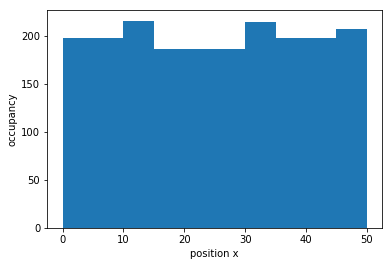

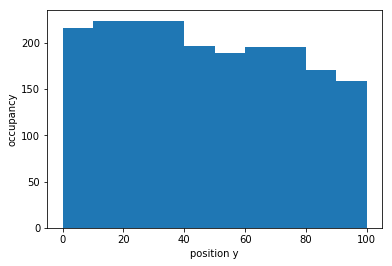

* 2D histogramming:

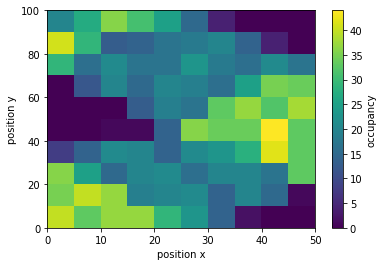